In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/Trush/datasetFull

Mounted at /content/drive
/content/drive/MyDrive/Trush/datasetFull


In [ ]:
import os
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications.convnext import ConvNeXtTiny,  preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from pathlib import Path
import numpy as np

# Classifier Report

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def ploat_ROC(y_true, y_score, title):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(y_score.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(8, 5))
  colors = ['blue', 'red', 'green']
  for i, color in zip(range(y_score.shape[1]), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title( title +' (one-vs-rest)')
  plt.legend(loc="lower right")
  plt.show()

def ploat_confusionMatrix(y_true, y_predict, title):
  conf_mat = confusion_matrix(y_true, y_predict)
  # print("Confusion matrix:\n", conf_mat)

  # Print confusion matrix as heatmap
  sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='g')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()

def ploat_AUC(y_true, y_score, title):
  n_classes = y_score.shape[1]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # Compute ROC curve and ROC area for each class
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot all ROC curves
  plt.figure()
  lw = 2
  colors = ['darkorange', 'cornflowerblue', 'purple']
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (AUC = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for ' + title )
  plt.legend(loc="lower right")
  plt.show()


def ploat_AUC_per_class(y_true, y_score, title):
  # compute AUC for each class
  n_classes = y_score.shape[1]
  auc_list = []
  for i in range(n_classes):
      auc = roc_auc_score(y_true == i, y_score[:, i])
      auc_list.append(auc)

  # plot AUC curve for class 0
  fpr, tpr, _ = roc_curve(y_true == 0, y_score[:, 0])
  plt.plot(fpr, tpr, label='Class 0 (AUC = %0.2f)' % auc_list[0])

  # set plot properties
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")

  plt.show()

def classificationReport(y_true, y_pred, title):
  print('Classification report for ' + title)
  print('\n')
  target_names = ['class 0', 'class 1', 'class 2']
  print(classification_report(y_true, y_pred, target_names=target_names))

# Augmentation

In [ ]:
BATCH_SIZE = 65
train_generator = ImageDataGenerator(rotation_range=45,
                                     brightness_range=[0.1, 0.9],
                                     width_shift_range=0.1,
                                     height_shift_range=0.15,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     shear_range=20.0,
                                    #  validation_split=0.30,
                                     fill_mode='nearest',
                                     featurewise_center=False,
                                     samplewise_center=False,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_dir = 'train'
test_data_dir = 'test'
validation_data_dir = 'Validation'

In [ ]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(512, 512),
                                               class_mode='categorical',
                                               classes=None,
                                              #  subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(validation_data_dir,
                                               target_size=(512, 512),
                                               class_mode='categorical',
                                               classes=None,
                                              #  subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(512, 512),
                                             class_mode=None,
                                             classes=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 983 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
Found 108 images belonging to 3 classes.


# Model

## SeNet

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Reshape, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras import backend as K


def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(0.01))(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(0.01))(se)
    x = multiply([init, se])
    return x

## ConvTiny

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = ConvNeXtTiny(
                    model_name="convnext_tiny",
                    include_top=False,
                    include_preprocessing=True,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=input_shape,
                    pooling=max,
                    #classes=1000,
                    classifier_activation="softmax",
                )


    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # new top
    top_model = conv_base.output

    seNet = squeeze_excite_block(top_model)

    top_model = Flatten(name="flatten")(seNet)
    top_model = Dense(256, activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)
    top_model = Dropout(0.4)(top_model)

    top_model = Dense(128, activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)

    top_model = Dropout(0.3)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
!pip install livelossplot --quiet

from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='model.hdf5',
                                  save_weights_only=True,
                                  monitor='val_loss',
                                  mode='min',
                                  save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=75,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
input_shape = (512, 512, 3)
n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 65

optimizer = Adam(learning_rate=0.0001)

# compile the model, 3 layers unfrozen for Fine-Tuning
convnexttiny = create_model(input_shape, n_classes, optimizer, fine_tune=3)

111650432/111650432 [==============================] - 1s 0us/step


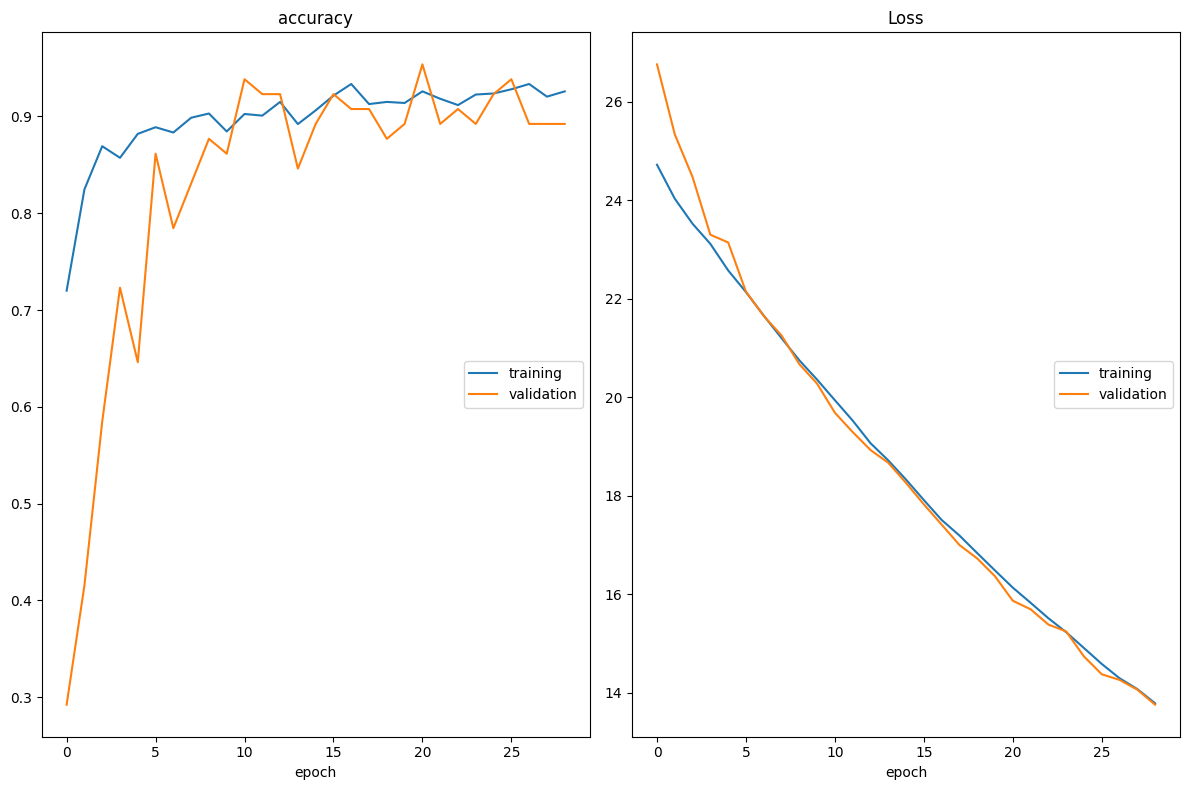

accuracy
	training         	 (min:    0.720, max:    0.934, cur:    0.926)
	validation       	 (min:    0.292, max:    0.954, cur:    0.892)
Loss
	training         	 (min:   13.785, max:   24.722, cur:   13.785)
	validation       	 (min:   13.756, max:   26.761, cur:   13.756)
15/15 [==============================] - 98s 6s/step - loss: 13.7848 - accuracy: 0.9259 - val_loss: 13.7560 - val_accuracy: 0.8923
Epoch 30/65
 2/15 [===>..........................] - ETA: 1:21 - loss: 13.5667 - accuracy: 0.9462

In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

convnexttiny_ft_history = convnexttiny.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
# Generate predictions

convnexttiny.load_weights('model.hdf5')

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

convnexttiny_preds_ft = convnexttiny.predict(testgen)
convnexttiny_pred_classes_ft = np.argmax(convnexttiny_preds_ft, axis=1)

108/108 [==============================] - 40s 249ms/step


In [ ]:
from sklearn.metrics import accuracy_score

convnexttiny_acc_ft = accuracy_score(true_classes, convnexttiny_pred_classes_ft)
print("ConvNeXtTiny Accuracy with Fine-Tuning 3 layers: {:.2f}%".format(convnexttiny_acc_ft * 100))

ConvNeXtTiny Accuracy with Fine-Tuning 3 layers: 92.59%


Classification report for ConvNeXtTiny


              precision    recall  f1-score   support

     class 0       0.90      0.98      0.94        53
     class 1       0.92      0.88      0.90        26
     class 2       1.00      0.86      0.93        29

    accuracy                           0.93       108
   macro avg       0.94      0.91      0.92       108
weighted avg       0.93      0.93      0.93       108





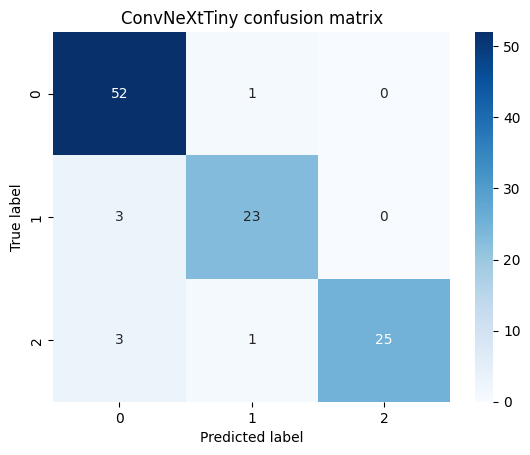

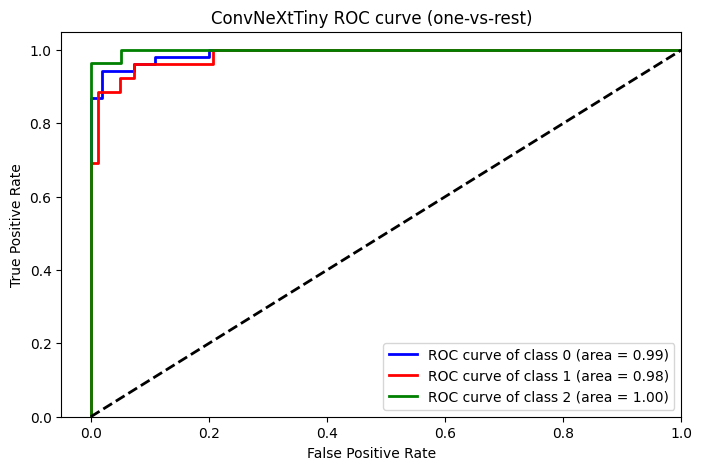

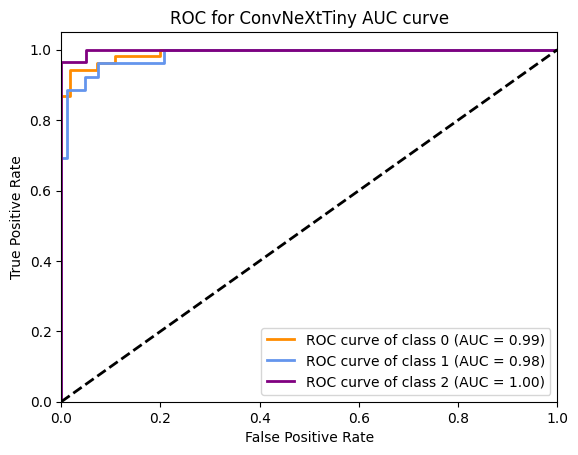

In [ ]:
classificationReport(true_classes, convnexttiny_pred_classes_ft, 'ConvNeXtTiny')
print('\n')
ploat_confusionMatrix(true_classes, convnexttiny_pred_classes_ft, 'ConvNeXtTiny confusion matrix')
print('\n')
ploat_ROC(true_classes, convnexttiny_preds_ft, "ConvNeXtTiny ROC curve")
print('\n')
ploat_AUC(true_classes, convnexttiny_preds_ft, "ConvNeXtTiny AUC curve")